# recurrent neural network (RNN) + Leu+ cys

In [1]:
import json
import os
from copy import deepcopy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

In [2]:
%load_ext autoreload
%autoreload 2
    
torch.manual_seed(1)

In [6]:
device = ("cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [7]:
df1 = pd.read_csv('/home/yuan/results/epitope/epitope.txt', sep='\t', header=None, index_col=None)
df2 = pd.read_csv('/home/yuan/results/epitope/other.txt', sep='\t', header=None, index_col=None)
df3 = pd.read_csv('/home/yuan/results/epitope/random.txt', sep='\t', header=None, index_col=None)

## without Cys but having Leu

In [37]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# select
select = df11[0].apply(lambda x: True if ('C' not in x and 'L' in x)  else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

df21 = df2.drop_duplicates()
df21 = df21.sample(frac=.5)
print(df2.shape, df21.shape)

df31 = df3.drop_duplicates()
df31 = df31.sample(frac=.4)
print(df3.shape, df31.shape)

(1865242, 2) (1865242, 2)
0
True     1155688
False     709554
Name: count, dtype: int64
(1155688, 2)
(3185991, 2) (1592996, 2)
(1863999, 2) (745599, 2)


In [38]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)
df.head()

(3494283, 2)


,0,1
581253,AATPSARAAA,other
260782,TCEQILRHQTYDQQRQ,random
1865780,GRGHKGERQRG,other
1010593,RKEAESSPFVERLL,epitope
1415340,EAVNRAITI,other


In [39]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'AATPSARAAA')
Counter({'other': 1592996, 'epitope': 1155688, 'random': 745599})


In [40]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('epitope', 'DVTVLRDNLKPVTTLS')
split data:  2096569 698856 698858

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: TPAAPRRFRRH ['T', 'P', 'A', 'A', 'P', 'R', 'R', 'F', 'R', 'R', 'H']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 2478350), ('A', 1749839), ('S', 1746348), ('E', 1619610), ('G', 1581768), ('V', 1535464), ('K', 1428783), ('P', 1410247), ('R', 1358238), ('T', 1336261), ('D', 1279656), ('I', 1188243), ('Q', 1155489), ('N', 1041109), ('F', 996252), ('Y', 841945), ('H', 745395), ('M', 668834), ('C', 541358), ('W', 511922), ('X', 1558), ('U', 42), ('Z', 23), ('B', 21), ('J', 2)])
counts of input: [956935, 692677, 446957]

## Step 3 encoding: encoding each unique token into integers...


In [41]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [42]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.8372 val_acc: 0.8472, val_recall: 0.8446
Epoch 1 acc: 0.8477 val_acc: 0.8497, val_recall: 0.8494
Epoch 2 acc: 0.8510 val_acc: 0.8516, val_recall: 0.8518
Epoch 3 acc: 0.8529 val_acc: 0.8516, val_recall: 0.8502
Epoch 4 acc: 0.8542 val_acc: 0.8521, val_recall: 0.8444
Epoch 5 acc: 0.8562 val_acc: 0.8524, val_recall: 0.8441
Epoch 6 acc: 0.8558 val_acc: 0.8529, val_recall: 0.8487
Epoch 7 acc: 0.8556 val_acc: 0.8519, val_recall: 0.8445
Epoch 8 acc: 0.8569 val_acc: 0.8531, val_recall: 0.8456
Epoch 9 acc: 0.8572 val_acc: 0.8503, val_recall: 0.8422
Epoch 10 acc: 0.8577 val_acc: 0.8537, val_recall: 0.8486
Epoch 11 acc: 0.8583 val_acc: 0.8530, val_recall: 0.8412
Epoch 12 acc: 0.8581 val_acc: 0.8539, val_recall: 0.8517
Epoch 13 acc: 0.8592 val_acc: 0.8536, val_recall: 0.8515
Epoch 14 acc: 0.8598 val_acc: 0.8530, val_recall: 0.8418
Epoch 15 acc: 0.8599 val_acc: 0.8517, val_recall: 0.8448
Epoch 16 acc: 0.8601 val_acc: 0.8538, val_recall: 0.8461
Epoch 17 acc: 0.8601 val_acc: 0.8535, val

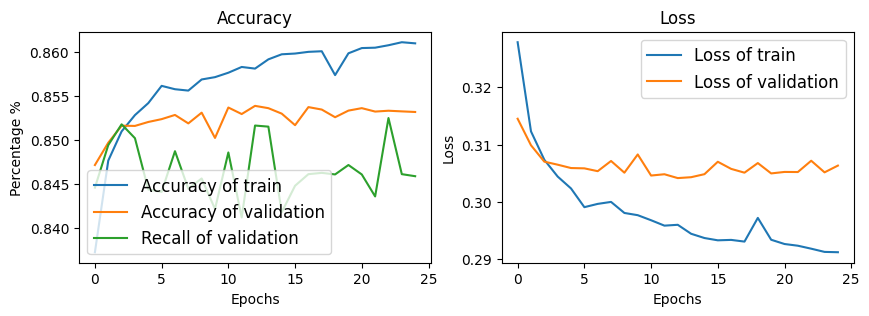

In [43]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [44]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.8448958553826782,
 'accuracy': 0.8527054136891901,
 'loss': 0.30644688016859745}

In [45]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]

231350 467508


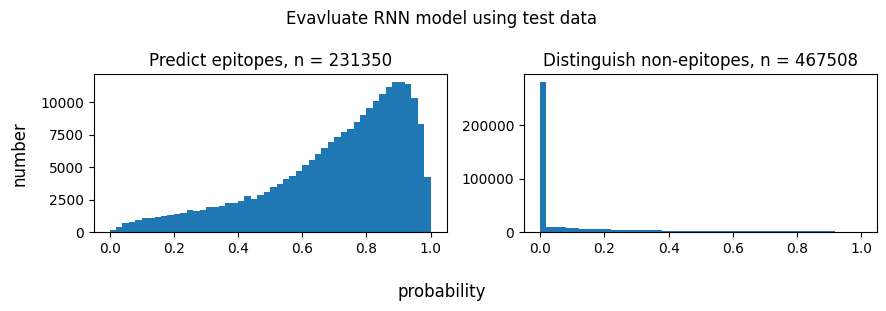

In [46]:
MyEvaluate.plot_prob(pred_test)

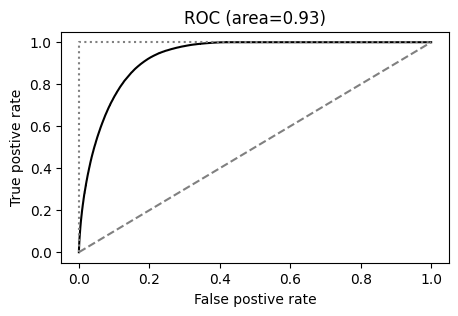

In [47]:
MyEvaluate.plot_roc(pred_test)

In [48]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_notCys_Leu.pth')

## has Cys and without Leu

In [49]:
df11 = df1.drop_duplicates()
print(df1.shape, df11.shape)
# keep Cys
select = df11[0].apply(lambda x: True if ('C' in x and 'L' not in x) else False)
print(select.value_counts())
df11 = df11.loc[select,:]
print(df11.shape)

(1865242, 2) (1865242, 2)
0
False    1797995
True       67247
Name: count, dtype: int64
(67247, 2)


In [50]:
df = pd.concat([df11, df21, df31])
df = df.sample(frac=1)
print(df.shape)

(2405842, 2)


In [51]:
from collections import Counter

# train_data = list(df.iloc[:10_000,:].apply(lambda x: (x[1], x[0]), axis=1))
train_data = list(df.apply(lambda x: (x[1], x[0]), axis=1))
print(train_data[0])
counts = Counter([i[0] for i in train_data])
print(counts)

('other', 'DELVTLVEWGMPPAA')
Counter({'other': 1592996, 'random': 745599, 'epitope': 67247})


In [52]:
# embedding
from seq.my_embedding import MyEmbedding

me = MyEmbedding(train_data)
train_ds, valid_ds, test_ds = me.split()
me.tokenize()
input_vocab, label_vocab = me.build_vocab()

example element of data:  ('other', 'CQFKLVLLGESAVGKS')
split data:  1443505 481168 481169

## Step 2 tokenization: unique tokens (words)...
A sentence converted to tokens: DECSENMCA ['D', 'E', 'C', 'S', 'E', 'N', 'M', 'C', 'A']
Vocab-size of input: 25
Vocab-size of labels: 3
OrderedDict([('L', 1246880), ('S', 1150177), ('A', 1084114), ('G', 1081841), ('E', 1050450), ('V', 964793), ('P', 953851), ('K', 905748), ('R', 895685), ('T', 880451), ('D', 871670), ('Q', 778754), ('I', 764178), ('N', 709248), ('F', 671263), ('C', 593291), ('Y', 571866), ('H', 547541), ('M', 515337), ('W', 432897), ('X', 1544), ('U', 45), ('Z', 18), ('B', 16), ('J', 1)])
counts of input: [955594, 447490, 40421]

## Step 3 encoding: encoding each unique token into integers...


In [53]:
from seq.my_collate import MyCollate
from seq.my_rnn import MyRnn
from seq.my_process import MyProcess

vocab_size = len(input_vocab)
embedding_dim = 48
model = MyRnn(vocab_size, embedding_dim).to(device)
print(model)

# training model
# update collate_batch
## Step 3-A: define the functions for transformation
# feed a tokens vector representing one sentence 
text_pipeline = lambda x: [input_vocab[token] for token in list(x)]
label_pipeline = lambda x: 1 if x == 'epitope' else 0
collate_fn = MyCollate(text_pipeline, label_pipeline)

MyRnn(
  (embedding): Embedding(27, 48, padding_idx=0)
  (rnn): LSTM(48, 64, num_layers=2, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


In [54]:
num_epochs = 25
p = MyProcess(model, collate_fn, num_epochs)
trained_model, stat = p.run(train_ds, valid_ds)

Epoch 0 acc: 0.9741 val_acc: 0.9748, val_recall: 0.6267
Epoch 1 acc: 0.9749 val_acc: 0.9747, val_recall: 0.6062
Epoch 2 acc: 0.9753 val_acc: 0.9753, val_recall: 0.6774
Epoch 3 acc: 0.9757 val_acc: 0.9747, val_recall: 0.7075
Epoch 4 acc: 0.9761 val_acc: 0.9762, val_recall: 0.6703
Epoch 5 acc: 0.9766 val_acc: 0.9763, val_recall: 0.7345
Epoch 6 acc: 0.9771 val_acc: 0.9770, val_recall: 0.6977
Epoch 7 acc: 0.9772 val_acc: 0.9766, val_recall: 0.6943
Epoch 8 acc: 0.9774 val_acc: 0.9770, val_recall: 0.6893
Epoch 9 acc: 0.9778 val_acc: 0.9770, val_recall: 0.7362
Epoch 10 acc: 0.9781 val_acc: 0.9773, val_recall: 0.7220
Epoch 11 acc: 0.9783 val_acc: 0.9775, val_recall: 0.7048
Epoch 12 acc: 0.9783 val_acc: 0.9772, val_recall: 0.7333
Epoch 13 acc: 0.9784 val_acc: 0.9774, val_recall: 0.7205
Epoch 14 acc: 0.9788 val_acc: 0.9773, val_recall: 0.7298
Epoch 15 acc: 0.9787 val_acc: 0.9774, val_recall: 0.7246
Epoch 16 acc: 0.9789 val_acc: 0.9775, val_recall: 0.7223
Epoch 17 acc: 0.9790 val_acc: 0.9772, val

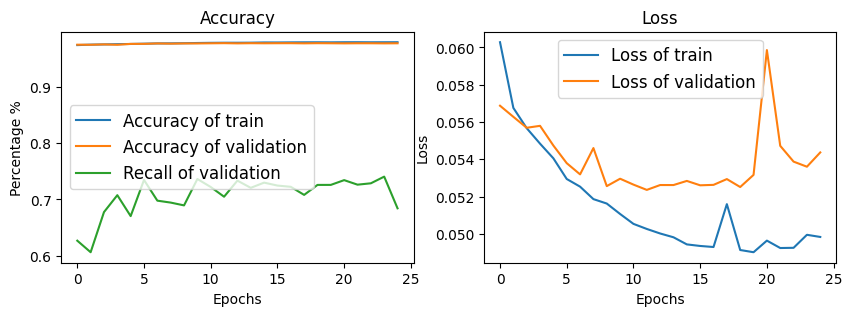

In [55]:
from seq.my_evaluate import MyEvaluate
MyEvaluate.plot_acc(stat)

In [56]:
# test model using test data
res = p.test(test_ds)
res

{'recall': 0.6859284890750336,
 'accuracy': 0.9772179837021919,
 'loss': 0.05471806306982262}

In [57]:
# distriubtion of prediction probability using test data
test_X = [i[1] for i in test_ds]
pred_test = p.predict(test_X)
pred_test['labels'] = [i[0] for i in test_ds]
pred_test.head()

,text,predict,labels
0,EPSTSCPP,0.050801,other
1,AVYFTLLQQGSILHLW,0.000000,random
2,YSVHNKQVL,0.000000,random
3,MAPFFEMKL,0.000000,other
4,EILVNTSSE,0.000000,other


13467 467702


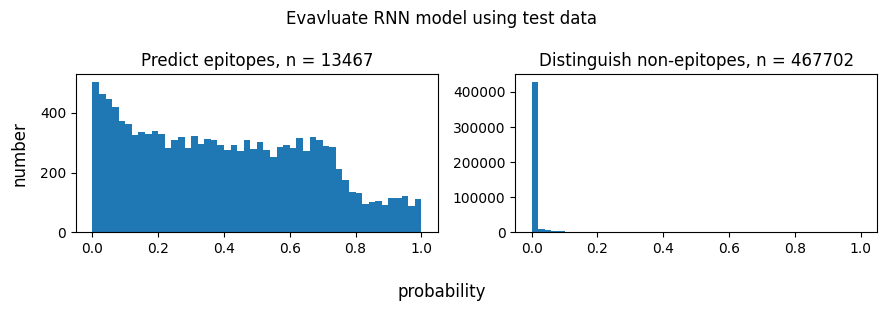

In [58]:
MyEvaluate.plot_prob(pred_test)

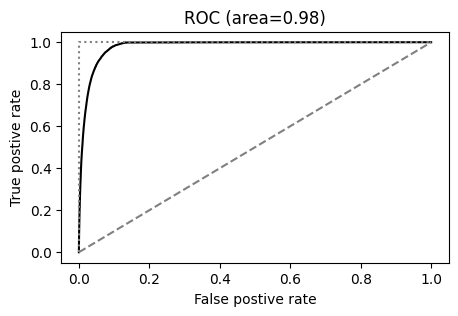

In [59]:
MyEvaluate.plot_roc(pred_test)

In [60]:
# save model
torch.save(model.state_dict(), '../models/epitopes_rnn_Cys_notLeu.pth')